In [1]:
import deeptime
from deeptime.decomposition import TICA
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import pandas as pd
import pyemma

%matplotlib inline

### Create TICA transformation from merged trajectories

We use the TICA coordinates resolved from the concatenated trajectories of our native systems to build the MSMs for each individual system. We show code below on how those TICA coordinates are obtained using our native system trajectories. 

However, we also provide the transformed TICA coordinates for each trajectory so that users can run the notebooks without the trajectory data.

In [2]:
# # Load in trajectories
# traj_path='/dfs9/dmobley-lab/osatom/msm_project/trajectories/'

# traj_4w52 = md.load([traj_path + f'4w52_4w52/{x}/F-helix-centered.xtc' for x in range(6)], top=traj_path + '4w52_4w52/0/F-helix-centered.pdb')
# traj_4w57 = md.load([traj_path + f'4w57_4w57/{x}/F-helix-centered.xtc' for x in range(6)], top=traj_path + '4w57_4w57/0/F-helix-centered.pdb')
# traj_4w59 = md.load([traj_path + f'4w59_4w59/{x}/F-helix-centered.xtc' for x in range(6)], top=traj_path + '4w59_4w59/0/F-helix-centered.pdb')
# traj = md.join([traj_4w52, traj_4w57, traj_4w59])

# helix_top = traj_path + '4w59_4w59/0/F-helix-centered.pdb'

In [3]:
# CaCb_feat = pyemma.coordinates.featurizer(helix_top)
# ##Add Ca - Ca distances (36)
# Ca_distance_pairs = CaCb_feat.pairs(CaCb_feat.select_Ca())
# CaCb_feat.add_distances(Ca_distance_pairs, periodic=False)

# ##Add Cb - Cb distances (15)
# indices = [a.index for a in CaCb_feat.topology.atoms if a.name == 'CB']
# Cb_distance_pairs = CaCb_feat.pairs(indices)
# CaCb_feat.add_distances(Cb_distance_pairs, periodic=False)

# output = CaCb_feat.transform(traj)

In [4]:
# # Initialize TICA
# CaCb_tica = TICA(lagtime=10, epsilon=1e-6,
#                 var_cutoff=0.95).fit(output)
# CaCb_tica_output = CaCb_tica.transform(output)

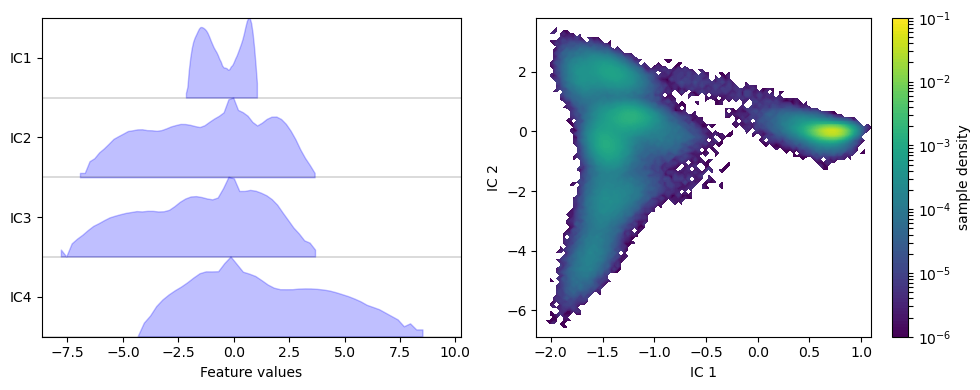

In [5]:
# fig, axes = plt.subplots(1, 2, figsize=(10,4))
# pyemma.plots.plot_feature_histograms(CaCb_tica_output[:,:4], ax=axes[0],
#     feature_labels=["tIC{}".format(i+1) for i in range(4)], ylog=True)
# pyemma.plots.plot_density(CaCb_tica_output[:,0], CaCb_tica_output[:,1], ax=axes[1], logscale=True)
# axes[1].set_xlabel('tIC1')
# axes[1].set_ylabel('tIC2')
# fig.tight_layout()

### Load in trajectories and transform onto TICA space

In [8]:
# def TICA_convert(traj, feat):
#     data = pyemma.coordinates.load(traj, features=feat)
#     return CaCb_tica.transform(data)

In [9]:
#structure = '4w57_4w59'
# tica_ = np.concatenate(TICA_convert([traj_path + f'{structure}/{x}/F-helix-centered.xtc' for x in range(10)], CaCb_feat))
#np.save('tica/4w57_4w59_tica.npy', tica_)

Obtaining file info:   0%|                                                                                    …

getting output of FeatureReader:   0%|                                                                        …

In [39]:
# Load in already transformed data
CaCb_tica_output = np.load('combined_traj_TICA.npy')
tica_ = np.load('tica/4w57_4w59_tica.npy')

## Create MSM

### Generate cluster centers for trajectory in TICA space

We initially discretize our TICA space by using k-means clustering to sample along the surface. We use 1000 cluster centers in order to sufficiently sample the surface, specifically with the hope of sampling regions of lower density. Again, we provide the pre-assigned cluster centers that can be loaded in.

In [20]:
# n_clustercenters = 1000

# kmeans = deeptime.clustering.KMeans(n_clustercenters, max_iter=50, fixed_seed=22)
# cluster = kmeans.fit(tica_)
# cluster_assign_ = cluster.transform(tica_)

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


/data/homezvol1/chrisyz1/.conda/envs/pyemma/lib/python3.11/site-packages/deeptime/clustering/_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"


In [4]:
#np.save('tica/4w57_4w59_cluster_assign.npy', cluster_assign_)
cluster_assign_ = np.load('tica/4w57_4w59_cluster_assign.npy')

In [21]:
# fig, axs = plt.subplots(figsize=(5,5))
# pyemma.plots.plot_density(CaCb_tica_output[:,0], CaCb_tica_output[:,1], ax=axs, cbar=False, alpha=0.3)
# axs.scatter(*cluster.model.cluster_centers[:,:2].T, s=20, color='orange')

### Evaluate implied timescales (ITS) for the system

We visualize the timescales of the slowest processes of our system using implied timescales (ITS) plots. Here, we observe how the timescales of each process changes as a function of different selected lag times.

In [6]:
from deeptime.markov import TransitionCountEstimator, pcca, PCCAModel
from deeptime.markov.tools.analysis import eigenvectors
from deeptime.markov.msm import BayesianMSM, MaximumLikelihoodMSM
from deeptime.plots import plot_implied_timescales, plot_markov_model
from deeptime.util.validation import implied_timescales, ck_test
from deeptime.plots.chapman_kolmogorov import plot_ck_test

In [33]:
# Assess choice of diffferent lag times

models = []
#lagtimes = np.array([5, 10, 20, 50, 100, 250, 500])
lagtimes = np.array([100, 150, 250, 350, 500, 750, 1000])
for lagtime in lagtimes:
    counts_estimator = TransitionCountEstimator(lagtime=lagtime, count_mode='sliding')
    counts = counts_estimator.fit(cluster_assign_).fetch_model()
    estimator = MaximumLikelihoodMSM(reversible=True, stationary_distribution_constraint=None)
    msm = estimator.fit(counts).fetch_model()
    models.append(msm)

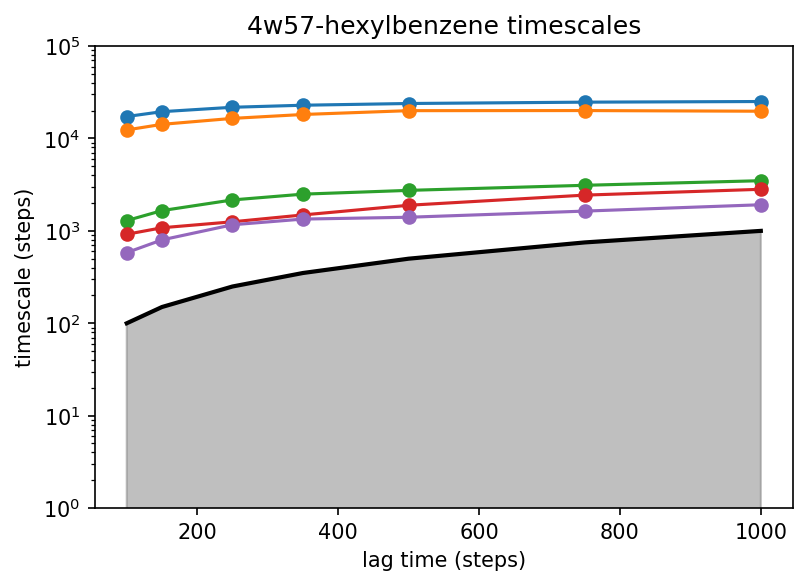

In [34]:
its_data = implied_timescales(models)
#print('Timescales for slowest process:', its_data.timescales_for_process(0))
fig, ax = plt.subplots(figsize=(6,4), dpi=150)
plot_implied_timescales(its_data, n_its=5, ax=ax, marker='o')
ax.set_ylim([1, 10**5])
ax.set_yscale('log')
ax.set_xlabel('lag time (steps)')
ax.set_ylabel('timescale (steps)')
ax.set_title('4w57-hexylbenzene timescales')
#fig.savefig('figures/4w57_4w59_its.png')
plt.show()

In [58]:
## Select msm with most appropriate lagtime (lowest value where processes start to level out)
selected_lag = np.where(lagtimes == 250)[0][0]
msm = models[selected_lag]

### Visualize slowest processes of the system 

First, we visualize the frames of the trajectory of the system plotted on the 2D TICA surface. The eigenvectors of the transition probability matrix correspond to the slowest motions of the system. By visualizing these eigenvectors, we can get a general sense of how many metastable states may be present in the system. 

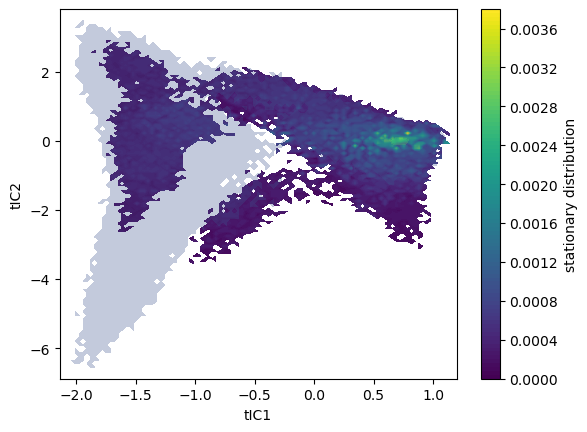

In [59]:
fig, axs, misc = pyemma.plots.plot_contour(tica_[:,0], tica_[:,1], msm.stationary_distribution[cluster_assign_],
                                         cbar_label='stationary distribution', method='nearest', mask=True)

pyemma.plots.plot_density(CaCb_tica_output[:,0], CaCb_tica_output[:,1], ax=axs, cbar=False, alpha=0.3, levels=1)

#axs.scatter(*cluster.model.cluster_centers[:,:2].T, s=5, color='orange', alpha=0.2)
axs.set_xlabel('tIC1')
axs.set_ylabel('tIC2')
plt.show()

In [60]:
eig_ = eigenvectors(msm.transition_matrix)

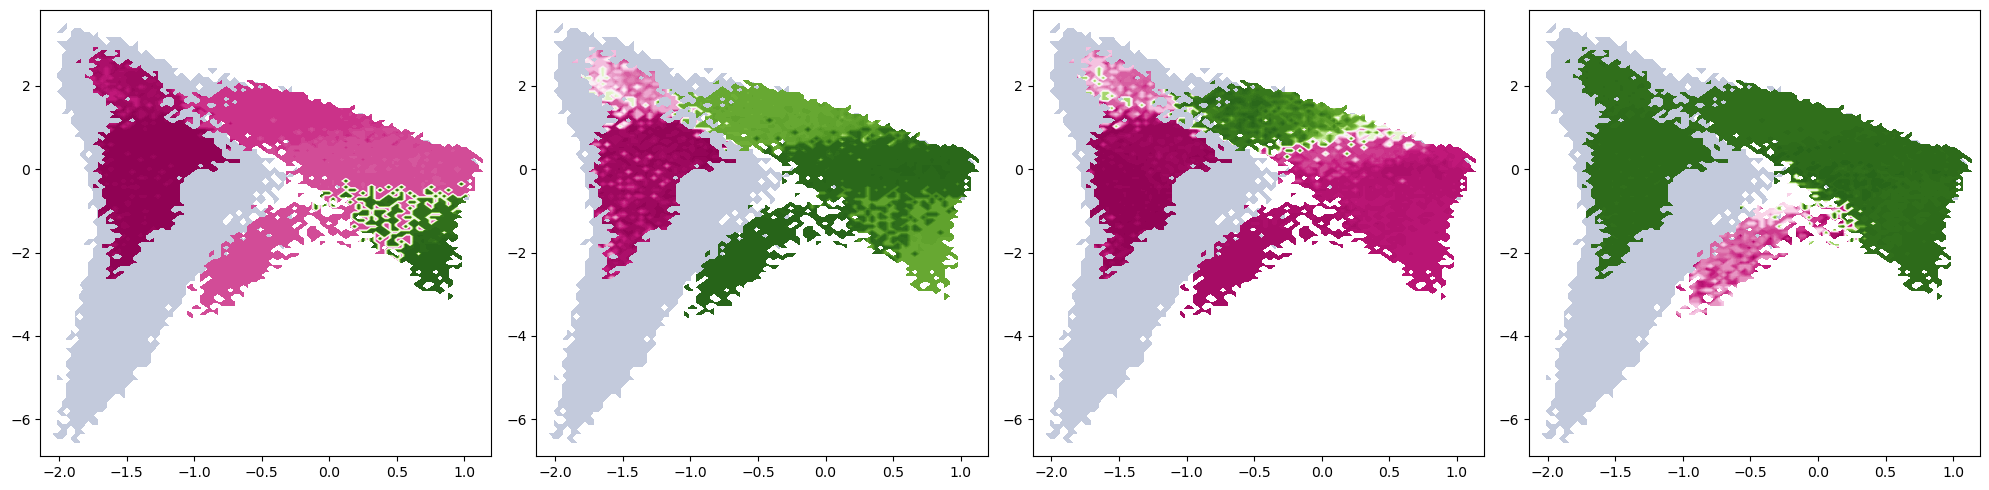

In [63]:
n_processes = 4
fig, axes = plt.subplots(1, n_processes, figsize=(5*n_processes, 5))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_density(CaCb_tica_output[:,0], CaCb_tica_output[:,1], ax=ax, cbar=False, alpha=0.3, levels=1)
    pyemma.plots.plot_contour(tica_[:,0], tica_[:,1], eig_[cluster_assign_, i+1], ax=ax, cmap='PiYG',
                             cbar_label=f'{i+2} right eigenvector', mask=True, cbar=False)

fig.tight_layout()

### Chapman-Kolmogorov (CK) test

We evaluate how well our model satisfies the condition of Markovianity using the CK test. Given a choice for the number of metastable states, we evaluate how well the model predictions at higher lag times agree with the model at the selected lag time. Significant deviation between these two suggests that the model is improperly constructed.

We can choose the number of metastable states by either looking at the number of significant slow processes from the ITS plot (processes much higher than the lag time) or using PCCA+, a spectral clustering method. 

In [64]:
# Test different number of metastable states
ck_ = msm.ck_test(models, n_metastable_sets=5)

/data/homezvol1/chrisyz1/.conda/envs/pyemma/lib/python3.11/site-packages/deeptime/plots/chapman_kolmogorov.py:174: ComplexWarning: Your CKtest contains imaginary components which are ignored during plotting.
  warnings.warn("Your CKtest contains imaginary components which are ignored during plotting.",


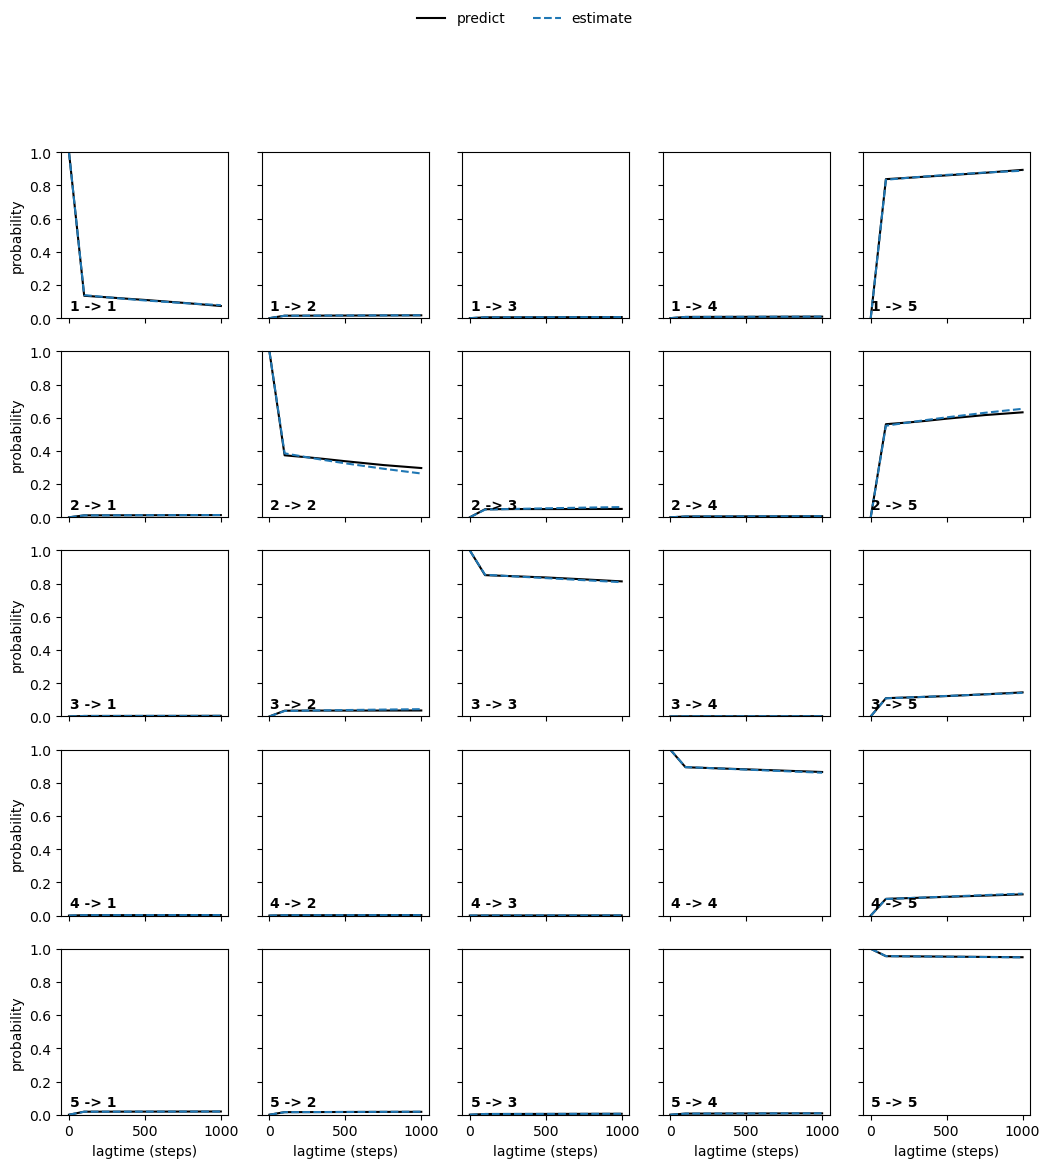

In [65]:
plot_ck_test(ck_)

In [20]:
## Size k x k where k is the number of k-means cluster centers
#print('Estimated transition matrix:', msm.transition_matrix)
#print('Estimated stationary distribution:', msm.stationary_distribution)

### Spectral clustering to coarse grain microstates into metastable macrostates

In [66]:
def pcca_states(n_states, trans_mat, tica_, d_traj):
    pcca_ = pcca(trans_mat, m=n_states)
    fig, axs = plt.subplots(1, n_states, figsize=(5*n_states,4), sharex=True, sharey=True)
    
    for i, ax in enumerate(axs.flat):
        pyemma.plots.plot_density(CaCb_tica_output[:,0], CaCb_tica_output[:,1], ax=ax, cbar=False, alpha=0.3, levels=1)
        pyemma.plots.plot_contour(tica_[:,0], tica_[:,1], pcca_.memberships[d_traj,i],
                                 ax=ax, cmap='RdYlBu', mask=True, cbar_label=f'metastable distribution {i+1}')
        ax.set_xlabel('tIC1')
    axs[0].set_ylabel('tIC2')
    fig.tight_layout()
    
    fig, axs = plt.subplots(figsize=(6,4))
    pyemma.plots.plot_density(CaCb_tica_output[:,0], CaCb_tica_output[:,1], ax=axs, cbar=False, alpha=0.3, levels=1)
    _, _, misc = pyemma.plots.plot_state_map(tica_[:,0], tica_[:,1], pcca_.assignments[d_traj], ax=axs)
    axs.set_xlabel('tIC1')
    axs.set_ylabel('tIC2')
    misc['cbar'].set_ticklabels([f'S$_{i}$' for i in range(n_states)])
    plt.show()

    return pcca_

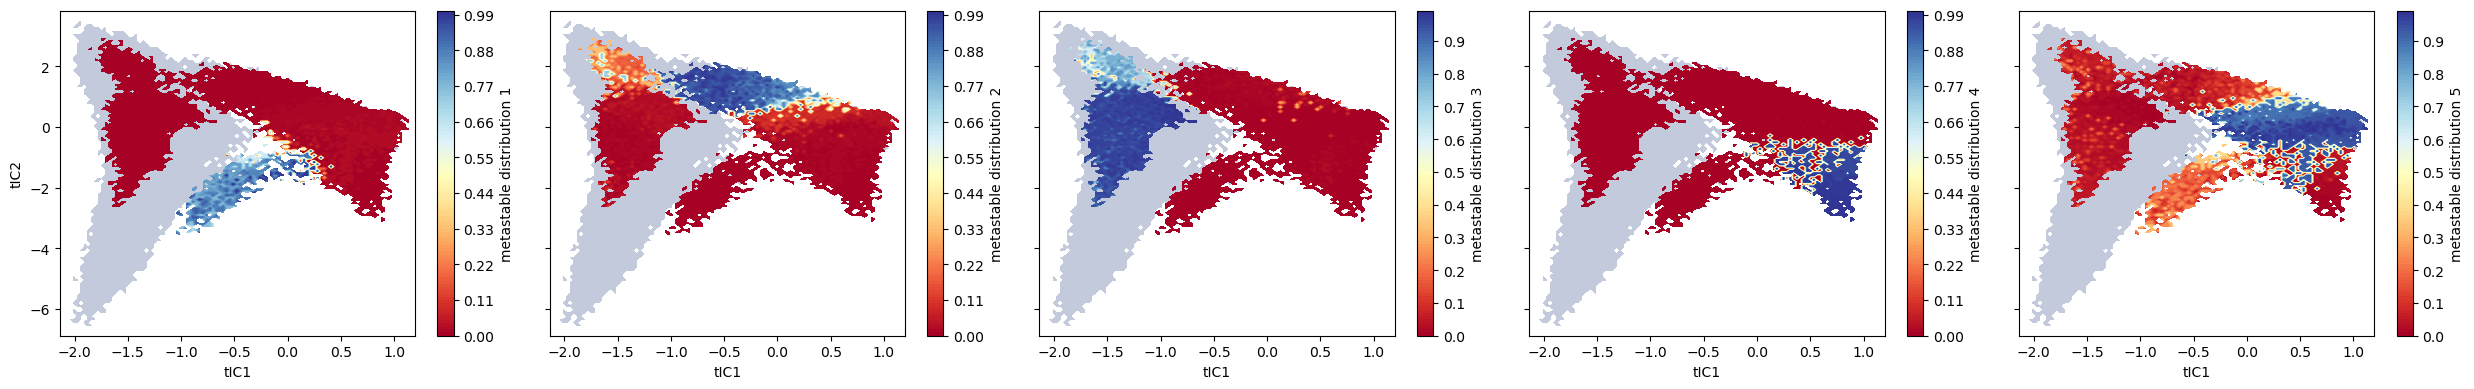

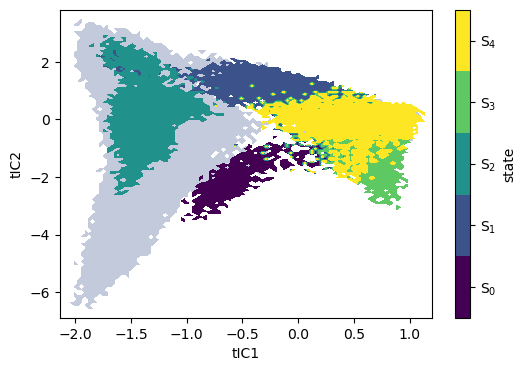

In [67]:
pcca_ = pcca_states(5, msm.transition_matrix, tica_, cluster_assign_)